<h1>European Football</h1>

<h2>Objective</h2>

* Investigate data set.
* Perform Data cleaning and exploratory data analysis.
* Perform statistical inference.
* Apply linear machine learning models to predict the Goal predictions and Winner outcomes.
* Create a dashboard.

<h3>Investigating the dataset</h3>

Dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european).
Supplementary dataset: [Supplementary Kaggle](https://www.kaggle.com/datasets/jiezi2004/soccer?select=goal_detail.csv).

<h1>Downloading data</h1>

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import missingno as msno

from scipy.stats import shapiro

from scipy import stats
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler


import seaborn as sns
import re

import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline

#Importing personal functions
%load_ext autoreload
%autoreload 2
from tools import helpingtool

In [2]:
"""Setting graph parameters"""
sns.set(style='whitegrid')
sns.set_palette('flare')

In [3]:
cnx = sqlite3.connect(r'..\Capstone\Archive\database.sqlite')
cursor = cnx.cursor()

helpingtool.sql_download(cursor)

Available tables: 

Table 'sqlite_sequence'
Features: ['name', 'seq']
Observations: 7 

Table 'Player_Attributes'
Features: ['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
Observations: 183978 

Table 'Player'
Features: ['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'height', 'weight']
Observations: 11060 

Table 'Match'
Features: ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_ap

* sqlite_sequence table describes the row count on the rest of the tables. 
* Date related columns are datetime types, but time component has no value.

In [4]:
for i in ['Player_Attributes', 'Match', 'Team_Attributes']:
    print(i, '\n', pd.read_sql_query(
        f"""SELECT DISTINCT STRFTIME('%H', date) AS hour, STRFTIME('%M', date) AS minute FROM {i}""", cnx))
for i in ['Player']:
    print(i, '\n', pd.read_sql_query(
        f"""SELECT DISTINCT STRFTIME('%H', birthday) AS hour, STRFTIME('%M', birthday) AS minute FROM {i}""", cnx))

Player_Attributes 
   hour minute
0   00     00
Match 
   hour minute
0   00     00
Team_Attributes 
   hour minute
0   00     00
Player 
   hour minute
0   00     00


In [5]:
# Each Country has their own League, so country_id and league_id have the same information.
league = pd.read_sql_query(""" 
                  SELECT l.id AS league_id, c.name AS Country, l.name AS League
                  FROM Country c
                  FULL OUTER JOIN League l
                  ON c.id=l.country_id
                  """, cnx)

player_attributes = pd.read_sql_query(
    """ SELECT * FROM Player_Attributes """, cnx).drop(columns=['id', 'player_fifa_api_id'])
team_attributes = pd.read_sql_query(
    """ SELECT * FROM Team_Attributes """, cnx).drop(columns=['id', 'team_fifa_api_id'])

# Updating pounds to kg
player = pd.read_sql_query(
    """ SELECT player_api_id, player_name, birthday, height, ROUND(weight / 2.2046, 1) AS weight FROM Player """, cnx)

team = pd.read_sql_query(
    """ SELECT team_api_id, team_long_name FROM Team """, cnx)

# Various betting odds (B365A, B365D, B365H, BSA, BSD, BSH, BWA, BWD, . . . .) will be removed
match = pd.read_sql_query(""" SELECT 
                          CASE 
                          WHEN home_team_goal > away_team_goal THEN 'home'
                          WHEN home_team_goal < away_team_goal THEN 'away'
                          ELSE 'draw' END AS win, *
                           
                          FROM Match """, cnx).loc[:, :'possession'].drop(columns=['country_id'])

cnx.close()

<h2>League</h2>
11 Leagues in total, no Leagues are missing

In [6]:
league = helpingtool.dtype_update(league)
helpingtool.first_look(league)

Column data types:
league_id     int64
Country      object
League       object
dtype: object

Dataset has 11 observations and 3 features
Columns with NULL values: []
Dataset has 0 duplicates


In [7]:
duckdb.query(""" 
            SELECT *
            FROM (SELECT DISTINCT league_id FROM match) m
            FULL OUTER JOIN league l
            ON m.league_id=l.league_id
            WHERE m.league_id IS NULL OR l.league_id IS NULL
            """).to_df().shape[0]

0

<h1>Player</h1>
Player table has 11060 observations and 6 features.

In [8]:
player = helpingtool.dtype_update(player)
helpingtool.first_look(player)

Column data types:
player_api_id             int64
player_name              object
birthday         datetime64[ns]
height                  float64
weight                  float64
dtype: object

Dataset has 11060 observations and 5 features
Columns with NULL values: []
Dataset has 0 duplicates


Height


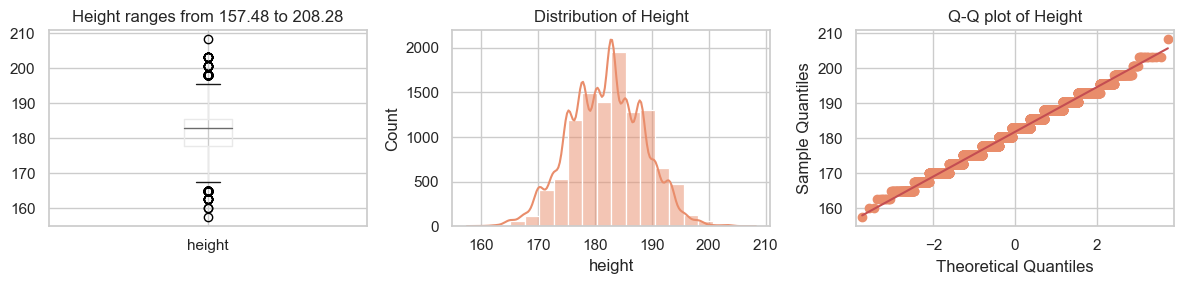

Weight


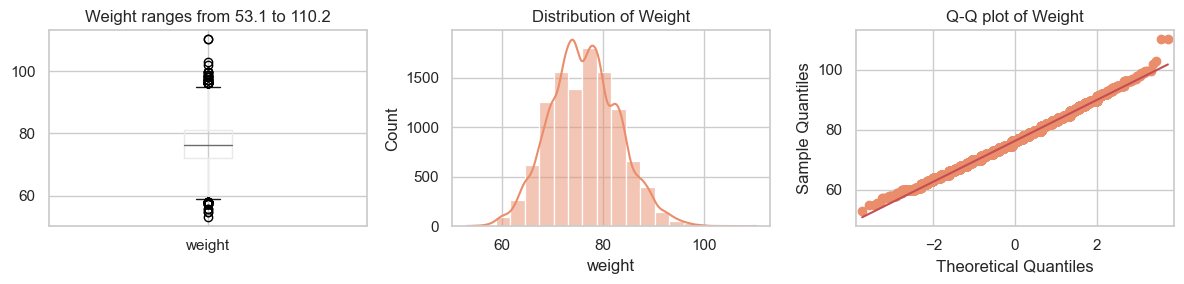

In [9]:
helpingtool.distribution_check(player.iloc[:, -2:])

Height and Weight are normally distributed and strongly positively linear correlated. BMI is not an ideal derived value, since it's not precise.

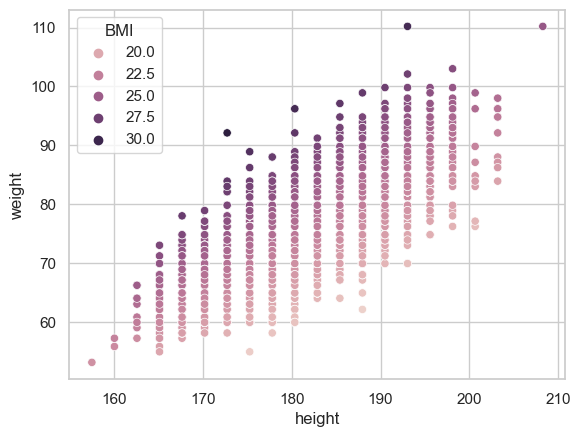

In [10]:
player['BMI'] = player['weight'] / pow(player['height']/100, 2)

sns. scatterplot(data=player, x='height', y='weight', hue='BMI')
plt.show()

Kristof van Hout is tall and heavy, his role is goalkeeper.

In [11]:
player[(player['height'] > 200) & (player['weight'] > 100)]

,player_api_id,player_name,birthday,height,weight,BMI
5901,148325,Kristof van Hout,1987-02-09,208.28,110.2,25.403085


Player Juan Quero weights the least and is not high, his role is Left/Right Middle and this role demands agility.

In [12]:
player[(player['height'] < 160) & (player['weight'] < 60)]

,player_api_id,player_name,birthday,height,weight,BMI
5446,97226,Juan Quero,1984-10-17,157.48,53.1,21.411333


<H1>Player Attributes</H1>
Player Attributes have 183978 observations and 40 features.

* Empty duplicated with only date + player_api_id available will be dropped.
* Some features are in-game only (i.e. attacking_work_rate, defensive_work_rate).
* Features related to skills will be aggregated for simplicity when making the models.

In [13]:
player_attributes = helpingtool.dtype_update(player_attributes)
helpingtool.first_look(player_attributes)

Column data types:
player_api_id                   int64
date                   datetime64[ns]
overall_rating                float64
potential                     float64
preferred_foot                 object
attacking_work_rate            object
defensive_work_rate            object
crossing                      float64
finishing                     float64
heading_accuracy              float64
short_passing                 float64
volleys                       float64
dribbling                     float64
curve                         float64
free_kick_accuracy            float64
long_passing                  float64
ball_control                  float64
acceleration                  float64
sprint_speed                  float64
agility                       float64
reactions                     float64
balance                       float64
shot_power                    float64
jumping                       float64
stamina                       float64
strength                      f

<h4>In-game only columns</h4>
attacking_work_rate, defensive_work_rate are cut of 2 index right for attacking_work_rate and 1 index left for defensive_work_rate. 

In the context of SOFIFA, "real face" refers to whether a player in the FIFA video game has an in-game character model that accurately reflects the player's real-life appearance. Those special columns are useless, because they are in game parameters only

In [14]:
duckdb.query("""
             SELECT DISTINCT
             attacking_work_rate
             ,defensive_work_rate

             ,CASE 
             WHEN attacking_work_rate = 'norm' AND defensive_work_rate = 'ormal' THEN 'normal'
             WHEN attacking_work_rate = 'le' AND defensive_work_rate = 'ean' THEN 'lean'
             WHEN attacking_work_rate = 'stoc' AND defensive_work_rate = 'tocky' THEN 'stocky'
             END AS body_type

             ,CASE 
             WHEN attacking_work_rate = 'y' AND defensive_work_rate = 'es' THEN 'yes'
             WHEN attacking_work_rate = 'None' AND defensive_work_rate = 'o' THEN 'no'
             END AS real_face   

             FROM player_attributes
             WHERE attacking_work_rate IN ('norm', 'le', 'stoc', 'y') 
             OR defensive_work_rate IN ('ormal', 'ean', 'tocky', 'es', 'o')
              """).to_df()

,attacking_work_rate,defensive_work_rate,body_type,real_face
0,y,es,None,yes
1,None,o,None,no
2,stoc,tocky,stocky,None
3,norm,ormal,normal,None
4,le,ean,lean,None


<h4>Preferred foot</h4>
Data on preferred foot is not ballanced and will not be used.

In [15]:
player_attributes['preferred_foot'].value_counts()

right    138409
left      44733
Name: preferred_foot, dtype: int64

<h2>Dublicates</h2>
Dataset has 1 duplicate and 836 duplicates for date + player_api_id, where the rest of the rows are empty. Duplicate and will be dropped.

In [16]:
result = helpingtool.remove_empty_dupes(
    player_attributes, ['player_api_id', 'date'])
player_attributes.shape[0] - result.shape[0]

836

In [17]:
player_attributes = result
helpingtool.first_look(player_attributes)

Column data types:
player_api_id                   int64
date                   datetime64[ns]
overall_rating                float64
potential                     float64
preferred_foot                 object
attacking_work_rate            object
defensive_work_rate            object
crossing                      float64
finishing                     float64
heading_accuracy              float64
short_passing                 float64
volleys                       float64
dribbling                     float64
curve                         float64
free_kick_accuracy            float64
long_passing                  float64
ball_control                  float64
acceleration                  float64
sprint_speed                  float64
agility                       float64
reactions                     float64
balance                       float64
shot_power                    float64
jumping                       float64
stamina                       float64
strength                      f

478 Players are missing attributes ['volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle'].

Missing attributes can be assigned to attacking, skill, movement, power, mentality, defending, goalkeeping. There's plenty of other features that describe simmilar attributes, so missing value columns will not be used.

In [18]:
player_attributes.loc[player_attributes[['volleys', 'curve', 'agility', 'balance', 'jumping',
                                         'vision', 'sliding_tackle']].isnull().all(axis=1), 'player_api_id'].drop_duplicates().shape[0]

478

In [19]:
player_attributes = player_attributes.drop(
    columns=['volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle'])

Having Player Attributes in feature buckets is a good prep for feature engineering.

In [20]:
attacking = ['crossing', 'finishing', 'heading_accuracy', 'short_passing']
skill = ['dribbling', 'free_kick_accuracy', 'long_passing', 'ball_control']
movement = ['acceleration', 'sprint_speed', 'reactions']
power = ['shot_power', 'stamina', 'strength', 'long_shots']
mentality = ['aggression', 'interceptions', 'positioning', 'penalties']
defending = ['marking', 'standing_tackle']
goalkeeping = ['gk_diving', 'gk_handling',
               'gk_kicking', 'gk_positioning', 'gk_reflexes']

<h2>Attacking</h2>
This work will use visual methods, such as Q-Q plots, histograms, to assess normality. Attacking attributes are normally distributed with left shift.

Crossing


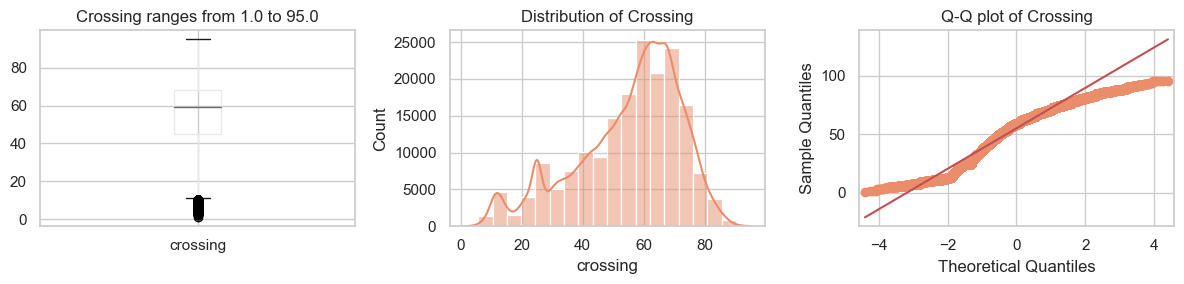

Finishing


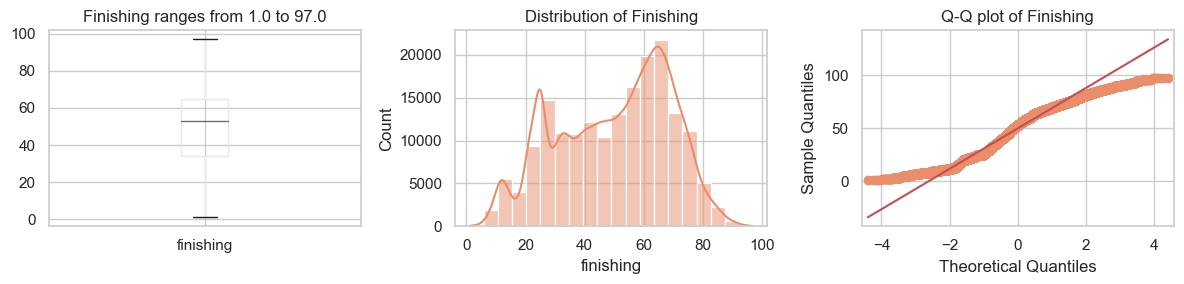

Heading_accuracy


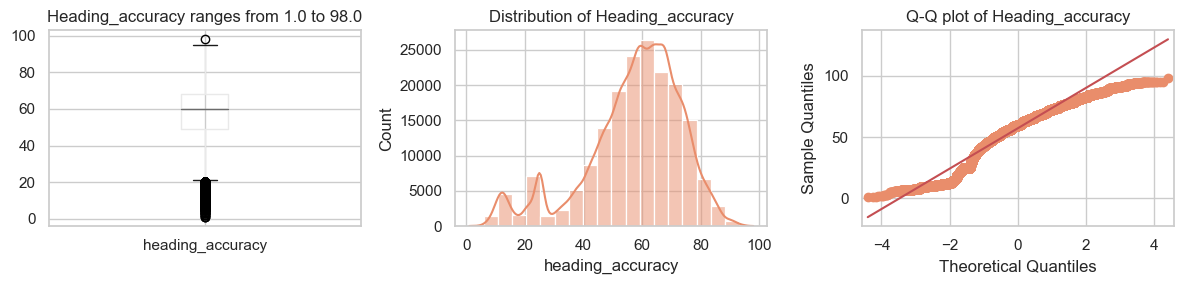

Short_passing


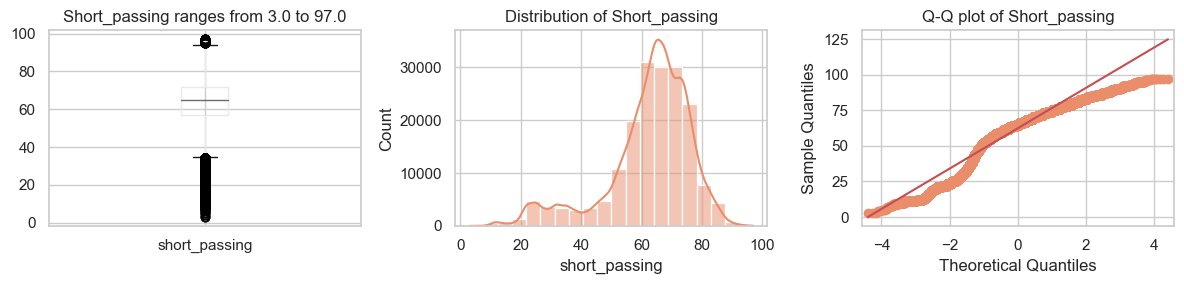

In [21]:
helpingtool.distribution_check(player_attributes[attacking])

<H3>Linear correlation</H3>
Strong Linear correlation (> 0.75) is seen between short_passing + crossing

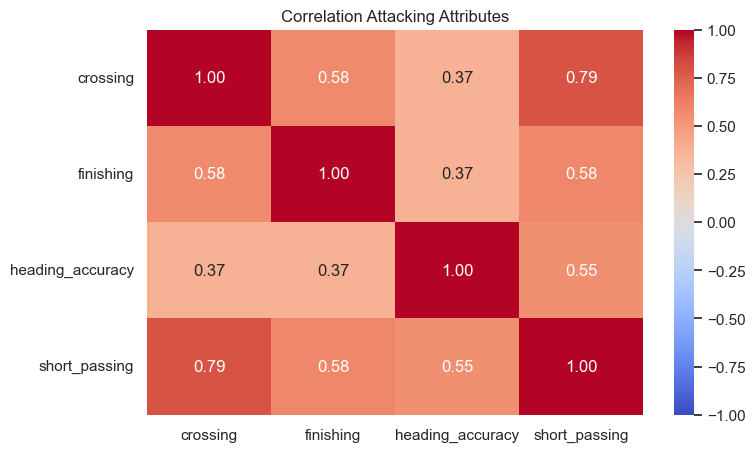

In [22]:
helpingtool.heatmap(player_attributes[attacking], 'attacking')

Due to collinearity of attacking related features, aggregation will be used to extract attacking data for each player. New feature is also rescaled.

In [23]:
player_attributes['attacking'] = helpingtool.feature_scaler(
    player_attributes, attacking)

<h2>Skill</h2>
Skill related features are normally distributed with left skew.

Dribbling


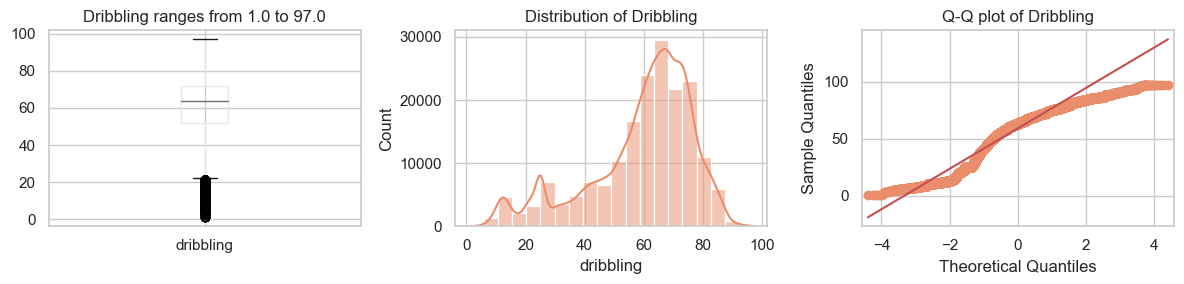

Free_kick_accuracy


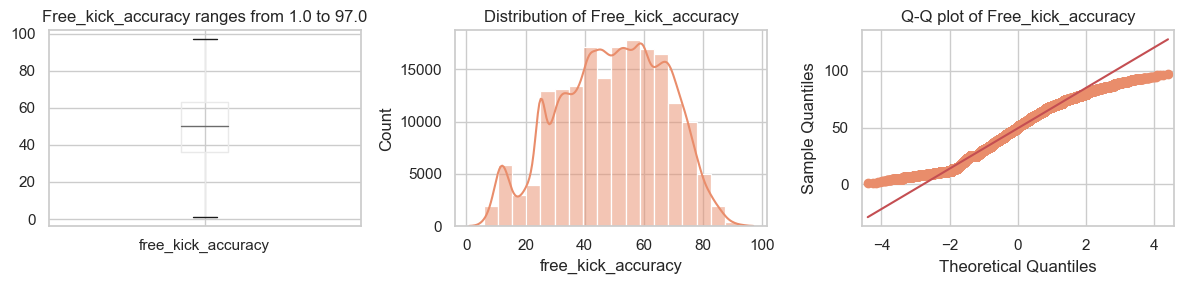

Long_passing


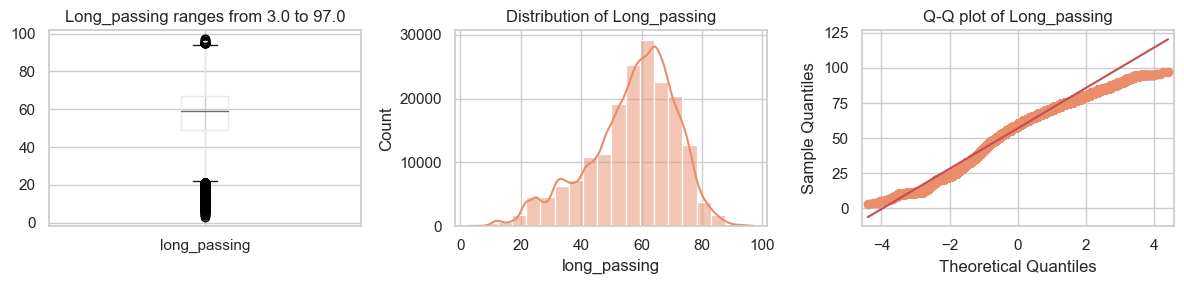

Ball_control


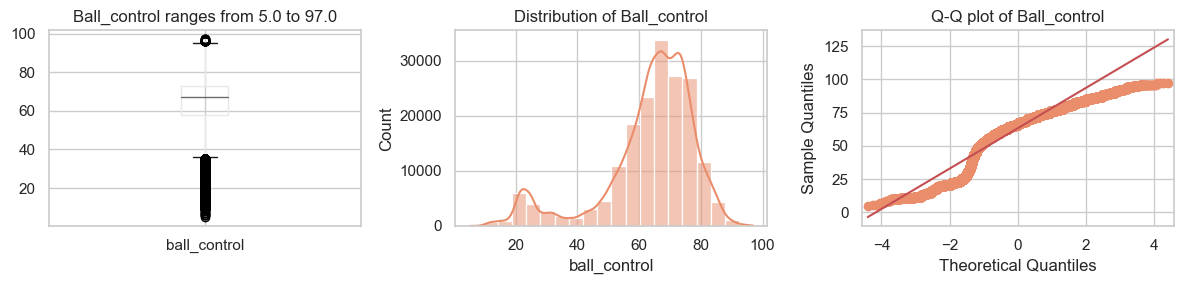

In [24]:
helpingtool.distribution_check(player_attributes[skill])

Strong Linear correlation is seen in all attributes, except with long_passing

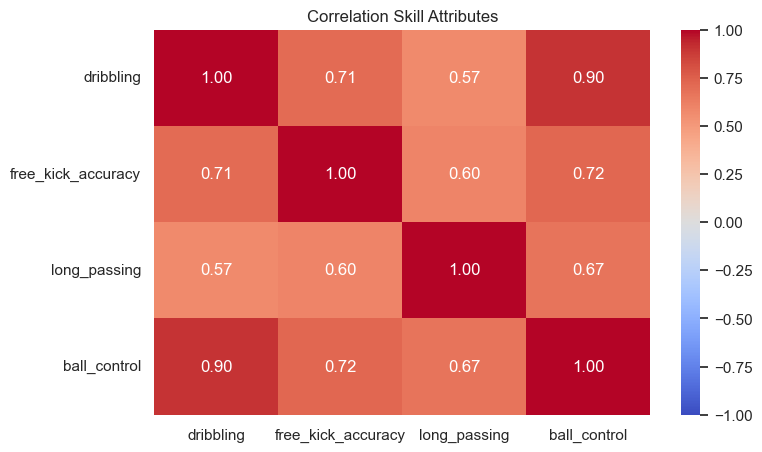

In [25]:
helpingtool.heatmap(player_attributes[skill], 'skill')

In [26]:
player_attributes['skill'] = helpingtool.feature_scaler(
    player_attributes, skill)

<h2>Movement</h2>
Movement related features are normally distributed.

Acceleration


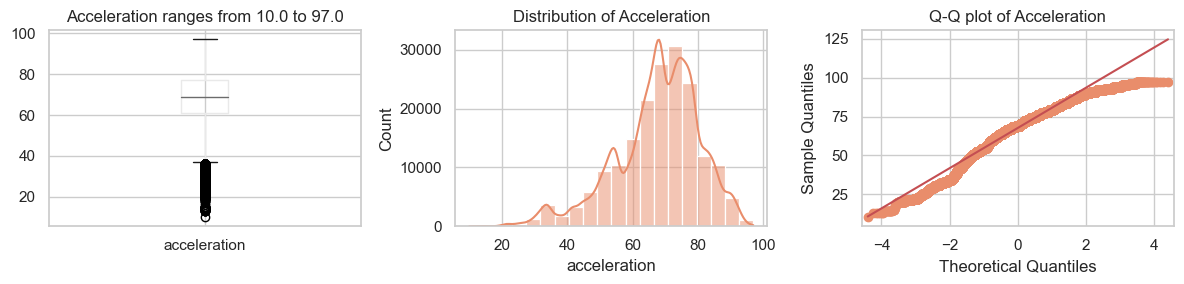

Sprint_speed


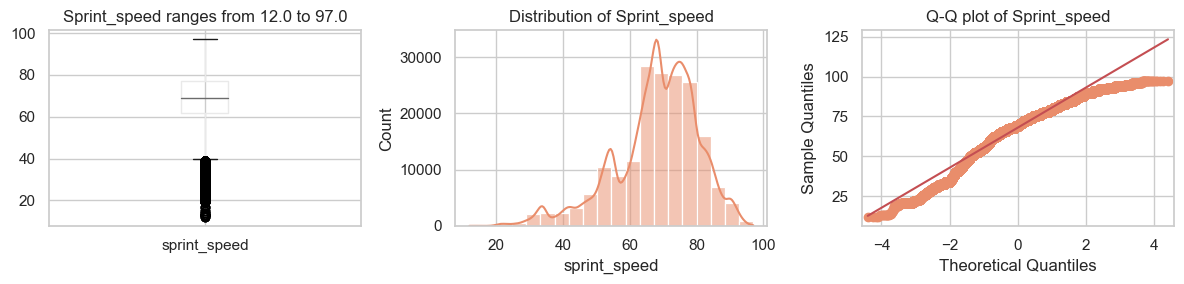

Reactions


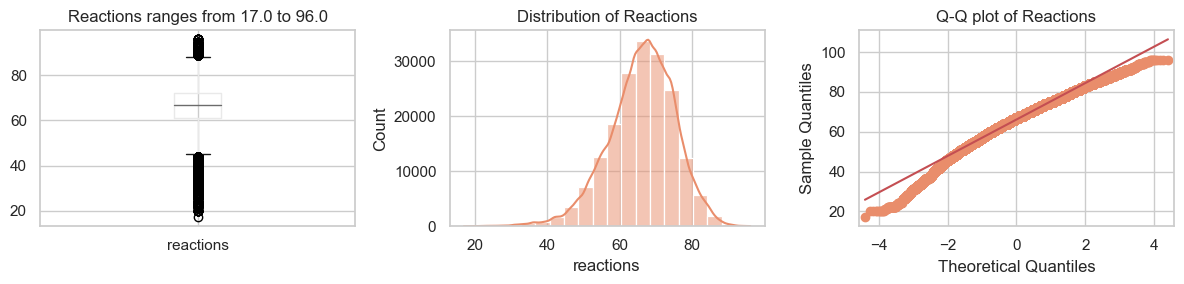

In [27]:
helpingtool.distribution_check(player_attributes[movement])

Strong Linear correlation is seen in all attributes, except with reaction.

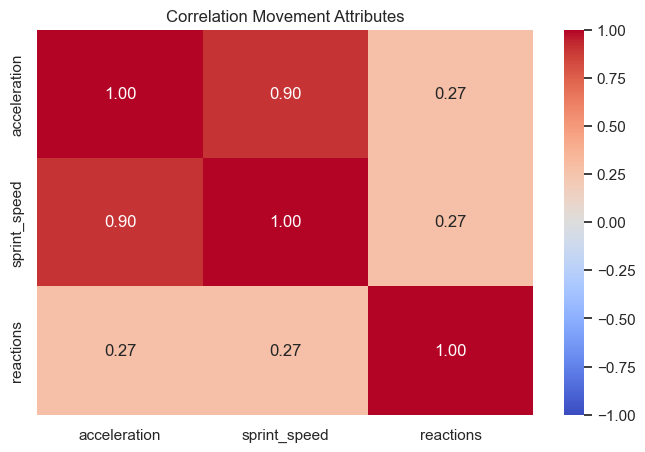

In [28]:
helpingtool.heatmap(player_attributes[movement], 'movement')

In [29]:
player_attributes['movement'] = helpingtool.feature_scaler(
    player_attributes, movement)

<h2>Power</h2>
Power related features are normally distributed with left skew.

Shot_power


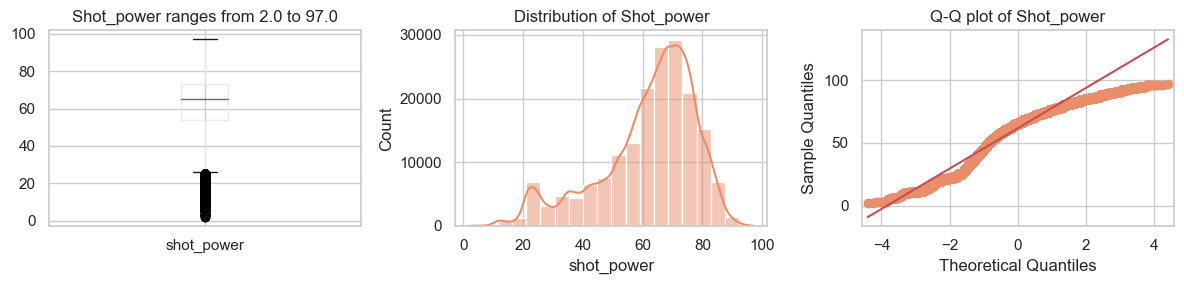

Stamina


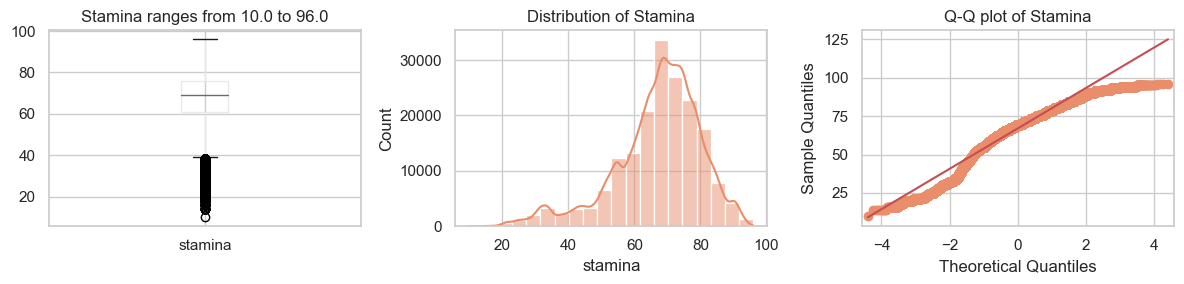

Strength


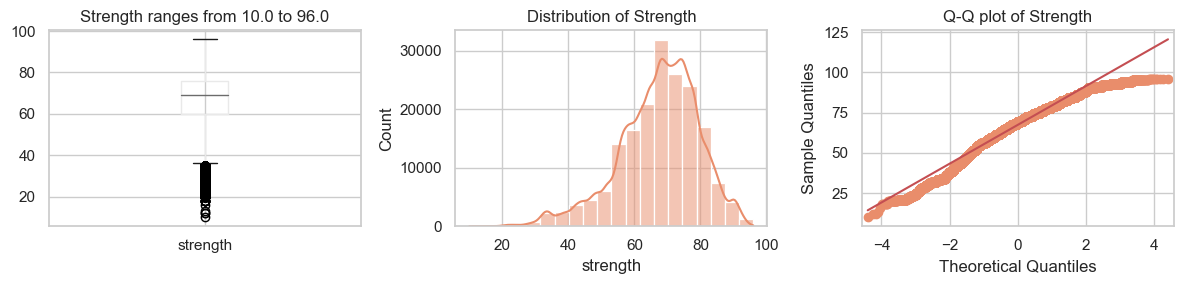

Long_shots


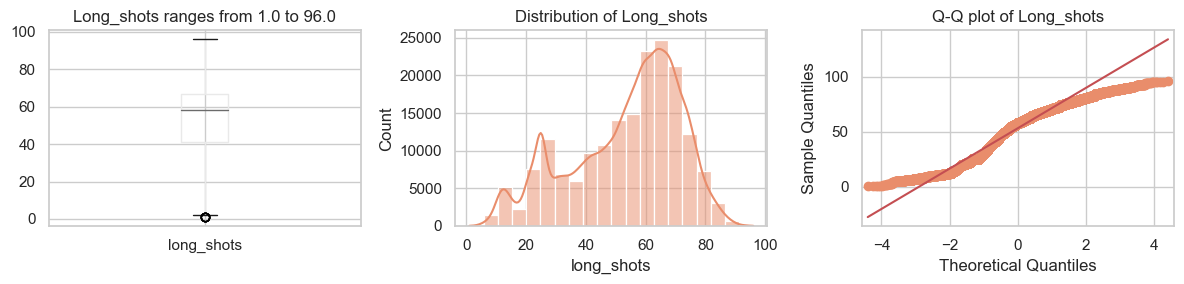

In [30]:
helpingtool.distribution_check(player_attributes[power])

shot_power and long_shot has strong positive correlation.

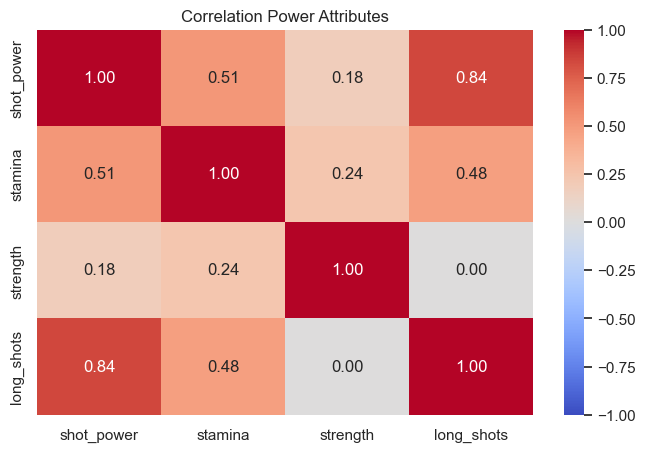

In [31]:
helpingtool.heatmap(player_attributes[power], 'power')

In [32]:
player_attributes['power'] = helpingtool.feature_scaler(
    player_attributes, power)

<h2>Mentality</h2>
Mentality related features are normally distributed with left skew.

Aggression


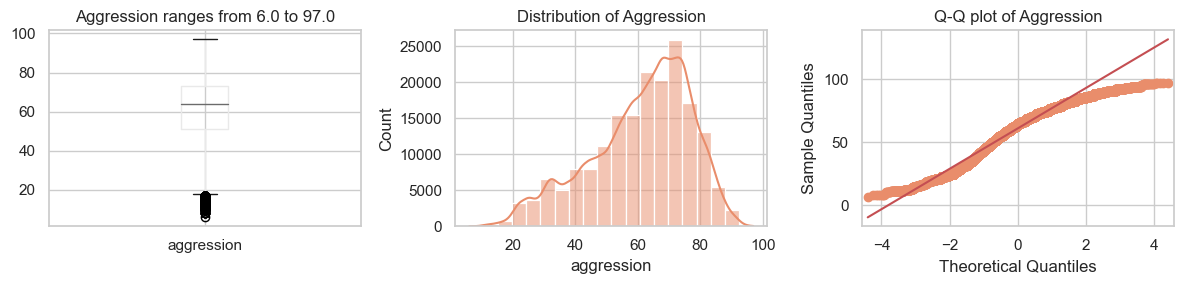

Interceptions


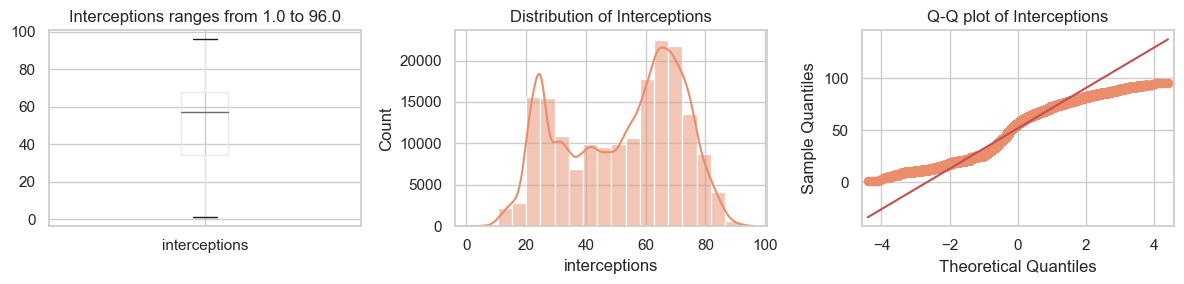

Positioning


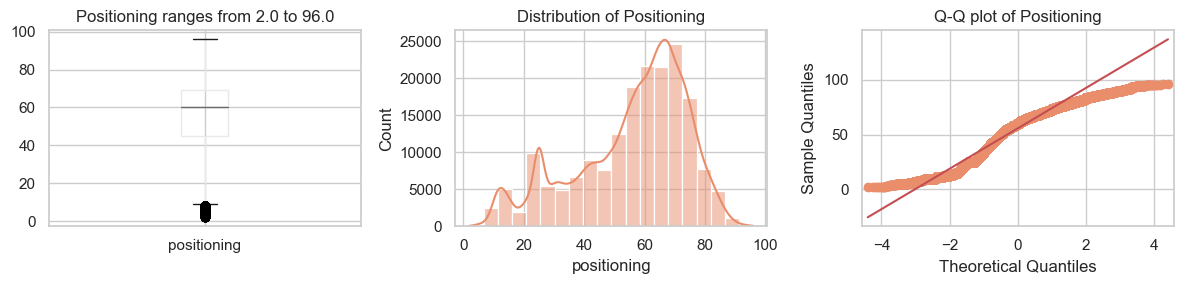

Penalties


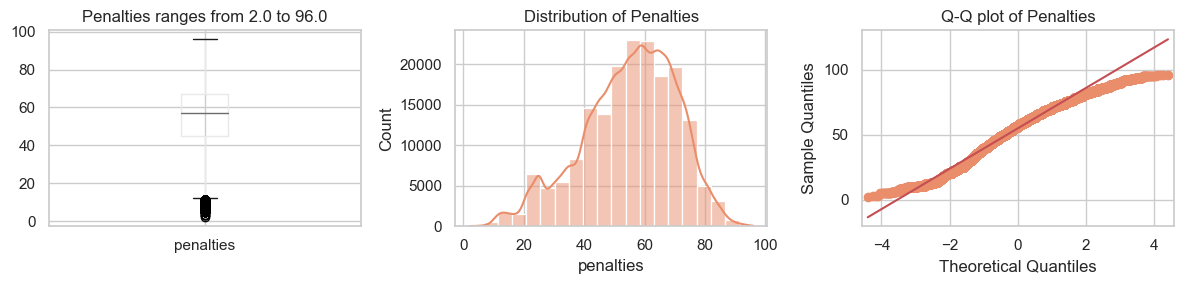

In [33]:
helpingtool.distribution_check(player_attributes[mentality])

positioning + penalties are strongly correlated.

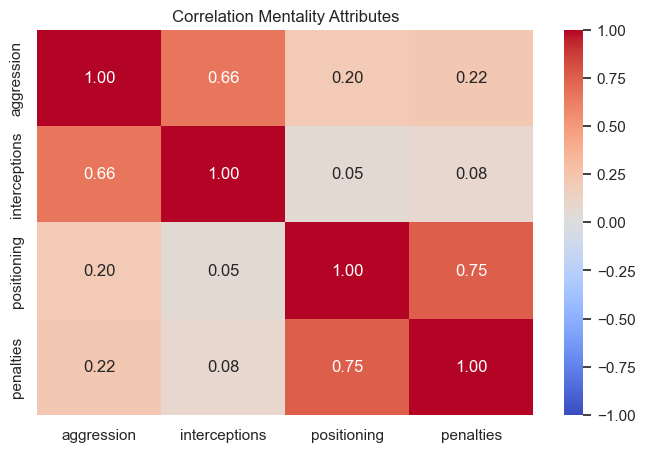

In [34]:
helpingtool.heatmap(player_attributes[mentality], 'mentality')

In [35]:
player_attributes['mentality'] = helpingtool.feature_scaler(
    player_attributes, mentality)

<h2>Defending</h2>
Defending has either all or nothing. Distribution looks almost binary.

Marking


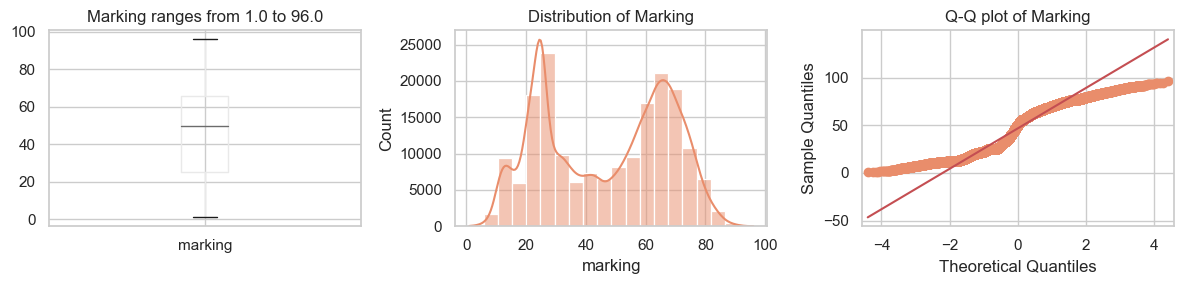

Standing_tackle


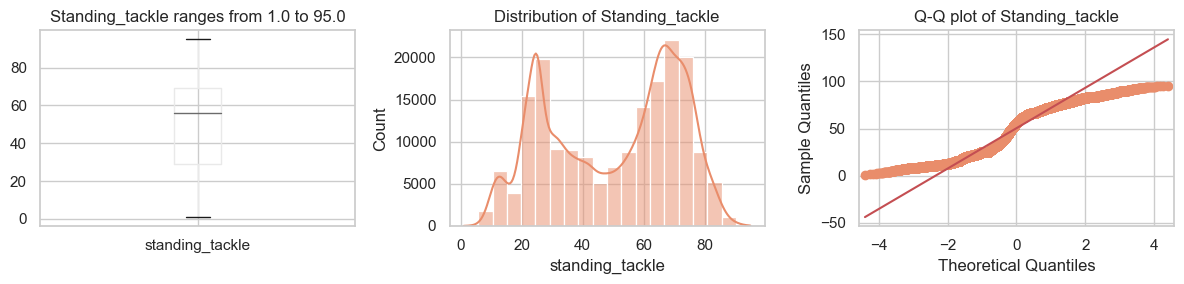

In [36]:
helpingtool.distribution_check(player_attributes[defending])

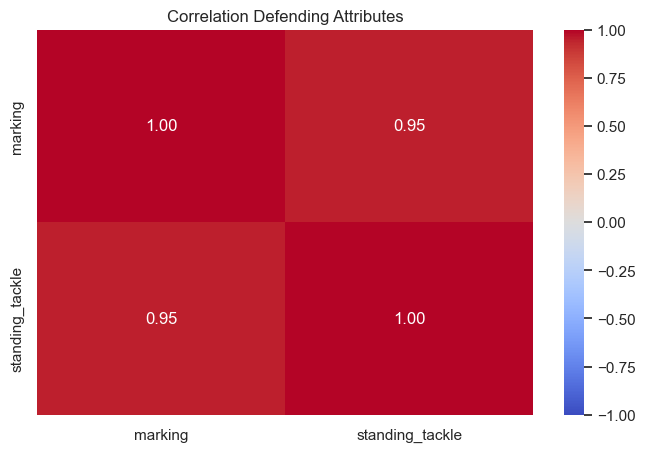

In [37]:
helpingtool.heatmap(player_attributes[defending], 'defending')

In [38]:
player_attributes['defending'] = helpingtool.feature_scaler(
    player_attributes, defending)

<h2>Goalkeeping</h2>
Goalkeeping related columns are log distributed. Transforming columns to make them approximately normally distributed.

Gk_diving


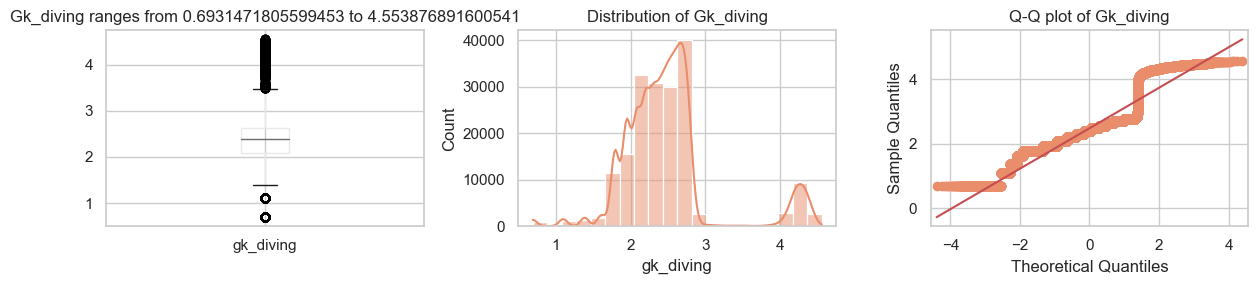

Gk_handling


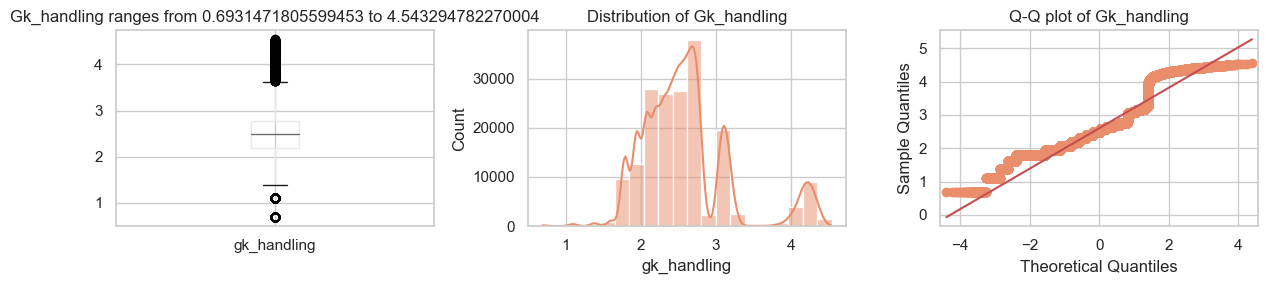

Gk_kicking


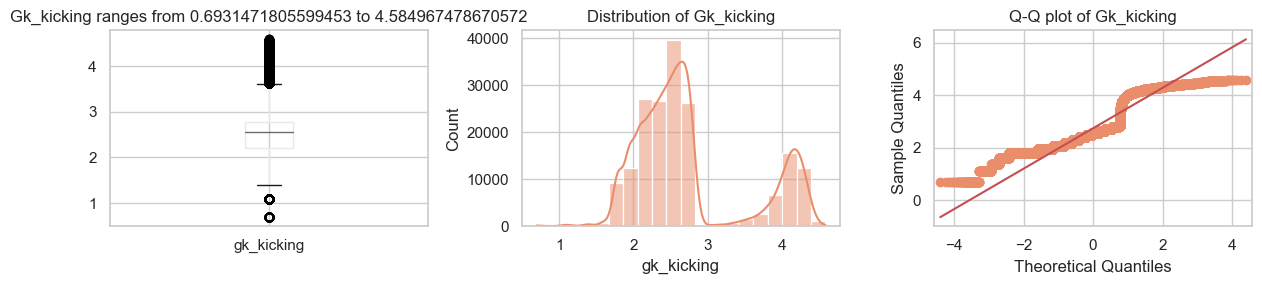

Gk_positioning


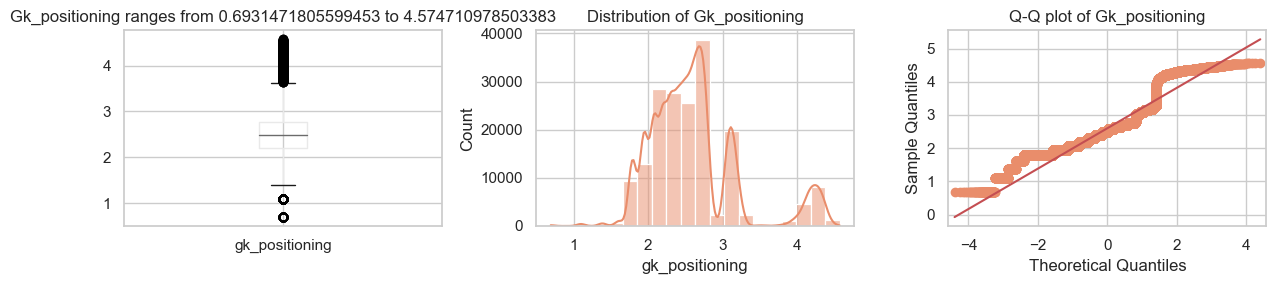

Gk_reflexes


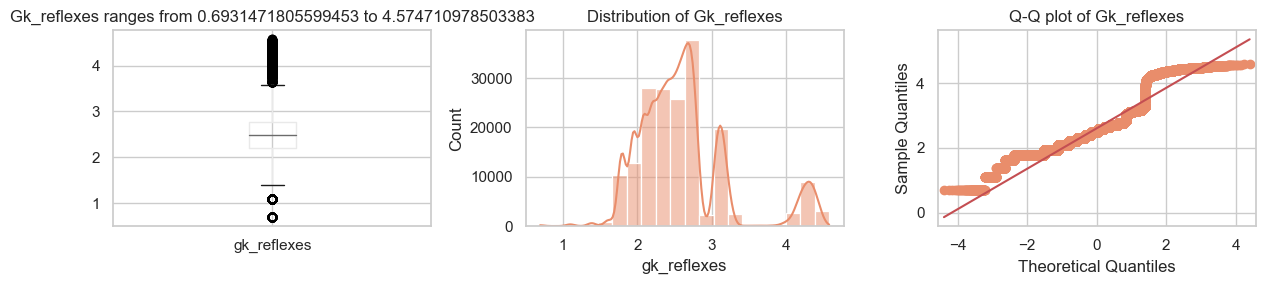

In [39]:
player_attributes[goalkeeping] = np.log1p(player_attributes[goalkeeping])
helpingtool.distribution_check(player_attributes[goalkeeping])

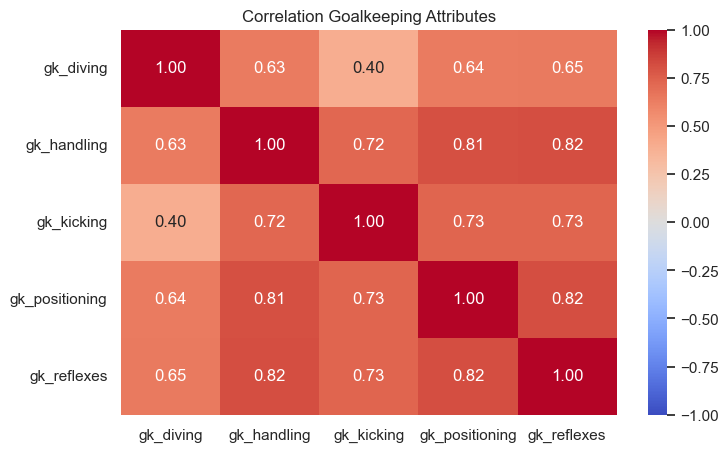

In [40]:
helpingtool.heatmap(player_attributes[goalkeeping], 'goalkeeping')

In [41]:
player_attributes['goalkeeping'] = helpingtool.feature_scaler(
    player_attributes, goalkeeping)

<h2>Aggregated features vs Overall Rating</h2>
Aggregated features (except defending and goalkeeping) are strongly correlated and multicollinear among each other. These features will be used in a model predictions and removed through testing, as the relationship with winning and goal making needs to be tested.

'overall_rating', 'potential' are multicollinear, but it's not clear how the in-game features were calculated. These features will not be used.

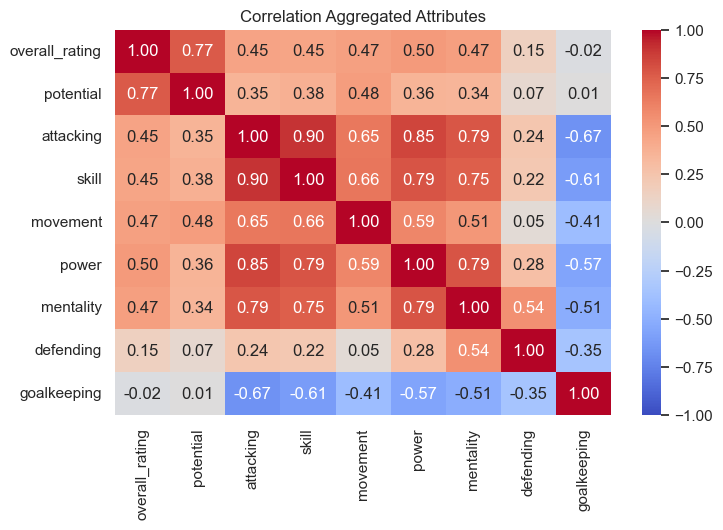

In [42]:
aggregated_features = ['attacking',
                       'skill', 'movement', 'power', 'mentality',
                       'defending', 'goalkeeping']

helpingtool.heatmap(player_attributes[[
                    'overall_rating', 'potential'] + aggregated_features], 'aggregated')

<h4>Date</h4>
Date ranges 2007 - 2016

In [43]:
player_attributes['date'].describe()

C:\Users\Gintare\AppData\Local\Temp\ipykernel_8468\328282155.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  player_attributes['date'].describe()


count                  183142
unique                    197
top       2007-02-22 00:00:00
freq                    11059
first     2007-02-22 00:00:00
last      2016-07-07 00:00:00
Name: date, dtype: object

<h4>Attribute Change in season </h4>
Player attributes do change for a season.

In [44]:
player_attributes = duckdb.query("""
             SELECT * 
             ,CASE 
             WHEN MONTH(date) > 6 THEN CONCAT(year, '/', year+1) 
             ELSE CONCAT(year - 1, '/', year)
             END AS season 
             FROM (
                SELECT *, YEAR(date) as year
                FROM player_attributes
             ) a
""").to_df()

In [45]:
duckdb.query("""
             SELECT * FROM (
             
             SELECT  
             COUNT(player_api_id) OVER (PARTITION BY season, player_api_id) 
             AS player_api_id_count

             ,season
             ,player_api_id
             FROM (
             SELECT DISTINCT player_api_id, attacking, skill, 
             movement, power, mentality, defending, goalkeeping  
             ,season
             FROM player_attributes
             ) a ) a
             WHERE  player_api_id_count!=1

""").to_df().shape[0]

100409

<H2>Multicollinearity</H2>
Multicollinearity occurs when two or more features in a model are highly correlated with each other, leading to redundant information or interference in the linear models. 


Variance Inflation Factor can predict Multicollinearity:

    VIF = 1/ (1-R^2)

R^2 - coefficient of determination

* VIF = 1, no correlation between the independent variable and the other variables
* VIF above 5 or 10 indicates high Multicollinearity between this independent variable and the others

Variance Inflation Factor (VIF) is specifically designed to detect Multicollinearity. VIF quantifies the severity of Multicollinearity in an ordinary least squares regression analysis. It's calculated by assessing how much the variance of a regression coefficient is inflated due to Multicollinearity in the model.

In [46]:
helpingtool.vif(player_attributes[['attacking', 'skill', 'movement', 'power', 'mentality', 'defending',
                                   'goalkeeping']])

,variables,VIF
0,attacking,129.099814
1,skill,83.548642
2,movement,41.210392
3,power,84.880357
4,mentality,83.803225
5,defending,9.850615
6,goalkeeping,7.484207


<h2>Conclussion</h2>
Player attributes are normally distributed, often with left skew and are correlated and multicollinear among each other. Goalkeeping features were log distributed. 

Features are aggregated and normalized.

Data ranges 2007-2016
Player attributes can change through the season.

<h1>Team</H1>
Team has 299 observations for player names.

In [47]:
team = helpingtool.dtype_update(team)
helpingtool.first_look(team)

Column data types:
team_api_id        int64
team_long_name    object
dtype: object

Dataset has 299 observations and 2 features
Columns with NULL values: []
Dataset has 0 duplicates


In [48]:
team[team['team_api_id'].duplicated()]

,team_api_id,team_long_name


<h1>Team Attributes</H1>
Team Attributes has 1458 observations and 23 features

In [49]:
team_attributes = helpingtool.dtype_update(team_attributes)
helpingtool.first_look(team_attributes)

Column data types:
team_api_id                                int64
date                              datetime64[ns]
buildUpPlaySpeed                           int64
buildUpPlaySpeedClass                     object
buildUpPlayDribbling                     float64
buildUpPlayDribblingClass                 object
buildUpPlayPassing                         int64
buildUpPlayPassingClass                   object
buildUpPlayPositioningClass               object
chanceCreationPassing                      int64
chanceCreationPassingClass                object
chanceCreationCrossing                     int64
chanceCreationCrossingClass               object
chanceCreationShooting                     int64
chanceCreationShootingClass               object
chanceCreationPositioningClass            object
defencePressure                            int64
defencePressureClass                      object
defenceAggression                          int64
defenceAggressionClass                    object
d

Duplicates are dropped, no empty rows found.

In [50]:
team_attributes = team_attributes.drop_duplicates()

result = helpingtool.remove_empty_dupes(
    team_attributes, ['team_api_id', 'date'])
team_attributes.shape[0] - result.shape[0]

0

Assigning skill buckets for team attributes.

In [51]:
buildUp = team_attributes.filter(like='buildUp', axis=1).columns.to_list()
chanceCreation = team_attributes.filter(
    like='chanceCreation', axis=1).columns.to_list()
defence = team_attributes.filter(like='defence', axis=1).columns.to_list()

<h2>Categorical and Continues features</h2>
Class related categorical columns are a derived from same name continues features.

3 features don't have corresponding continues features:
* buildUpPlayPositioningClass 
* chanceCreationPositioningClass 
* defenceDefenderLineClass

Class columns are always set into 3 categories and have category change at 34 and 66 value.

In [52]:
team_attributes[team_attributes['buildUpPlayDribblingClass'] ==
                'Normal']['buildUpPlayDribbling'].drop_duplicates().describe().loc[['min', 'max']]

min    34.0
max    66.0
Name: buildUpPlayDribbling, dtype: float64

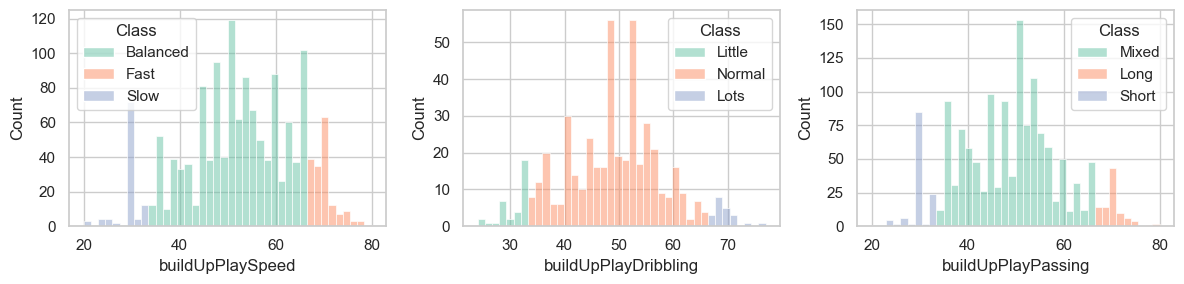

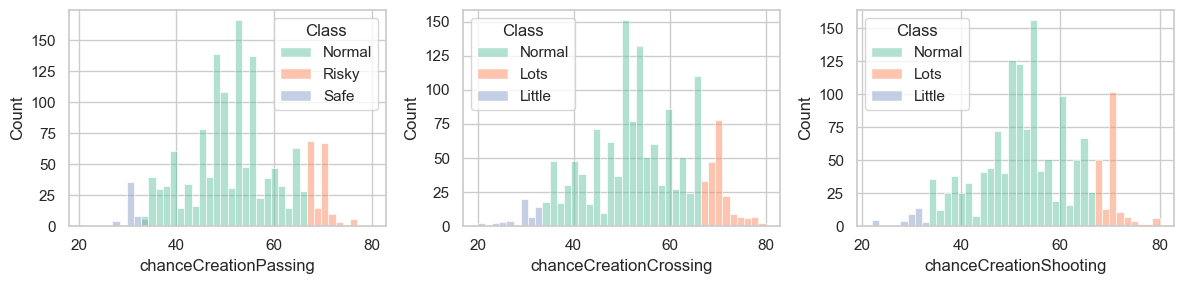

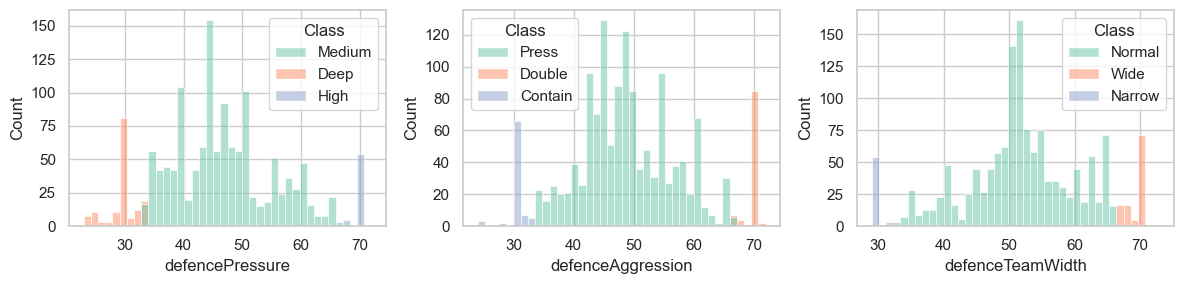

In [53]:
for features in [buildUp, chanceCreation, defence]:
    helpingtool.class_distribution(team_attributes, features)

<h3>Missing values</h3>
Table has only 1 column with NaN values - buildUpPlayDribbling. A coresponding Class columns has NaN values as 'Little'. This feature can be replaced by the Class feature.

In [54]:
team_attributes[team_attributes['buildUpPlayDribbling'].isnull(
)]['buildUpPlayDribblingClass'].drop_duplicates()

0    Little
Name: buildUpPlayDribblingClass, dtype: object

In [55]:
buildUp.remove('buildUpPlayDribbling')

<h3>Distribution of Continues features</h3>
All continuess features are normaly distributed.

Buildupplayspeed


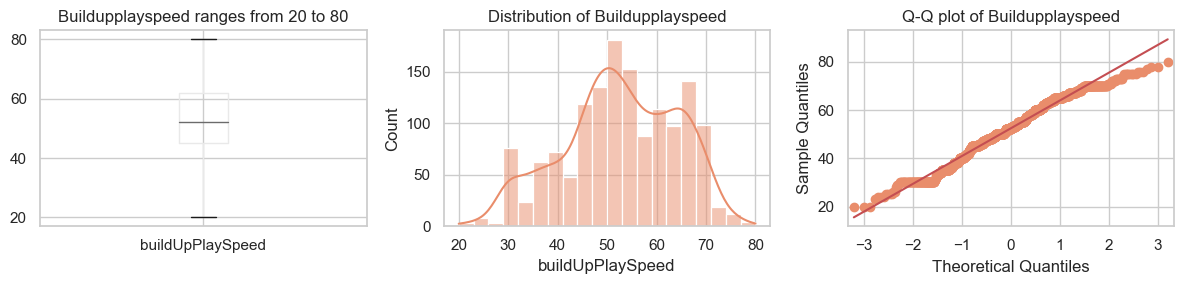

Buildupplaypassing


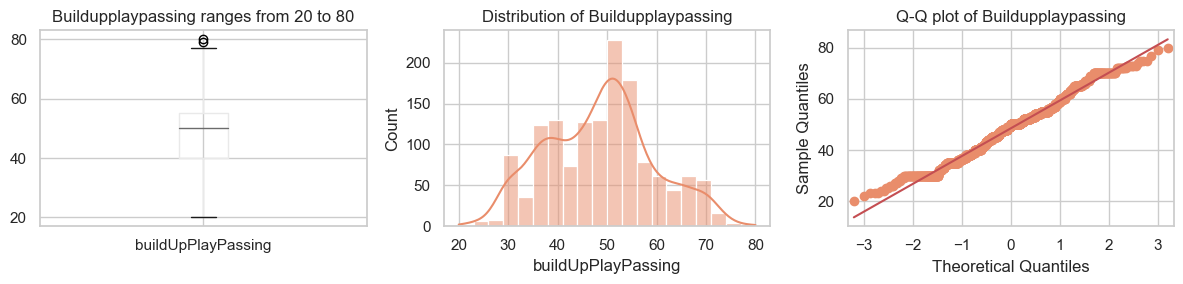

Chancecreationpassing


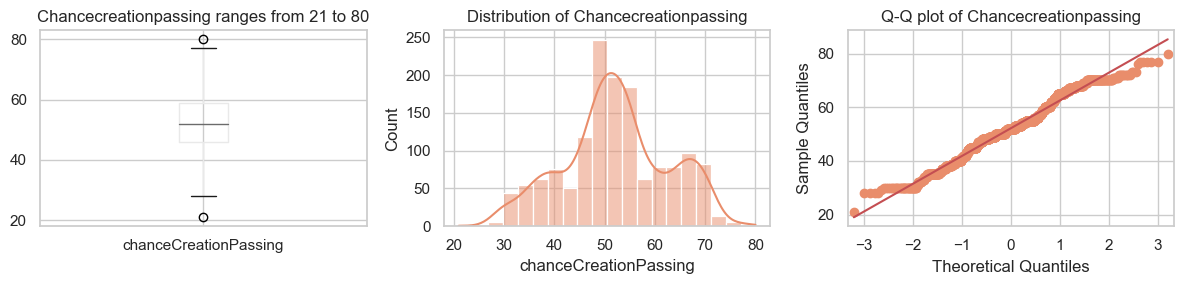

Chancecreationcrossing


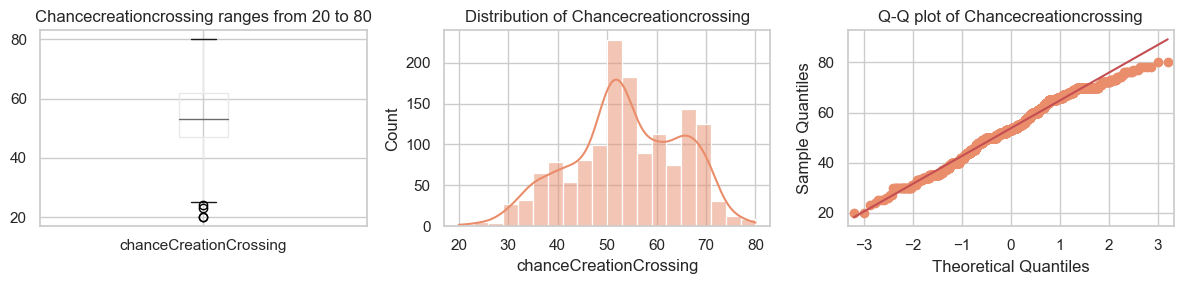

Chancecreationshooting


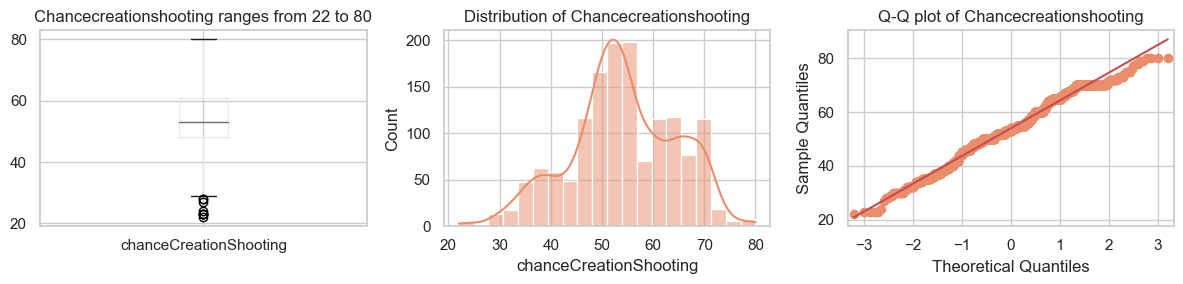

Defencepressure


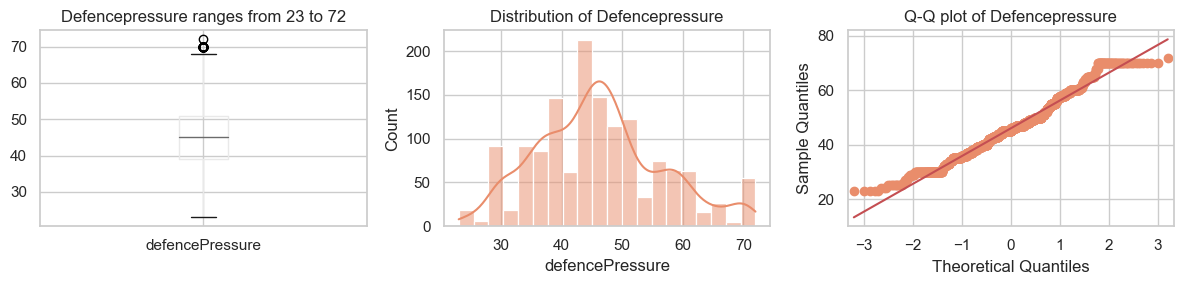

Defenceaggression


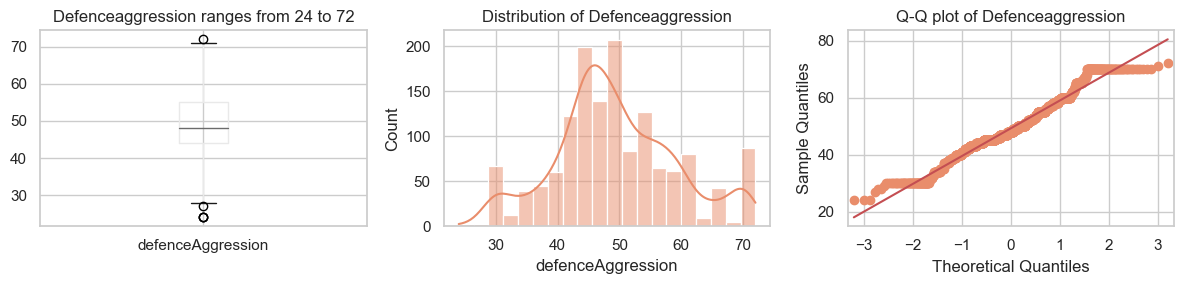

Defenceteamwidth


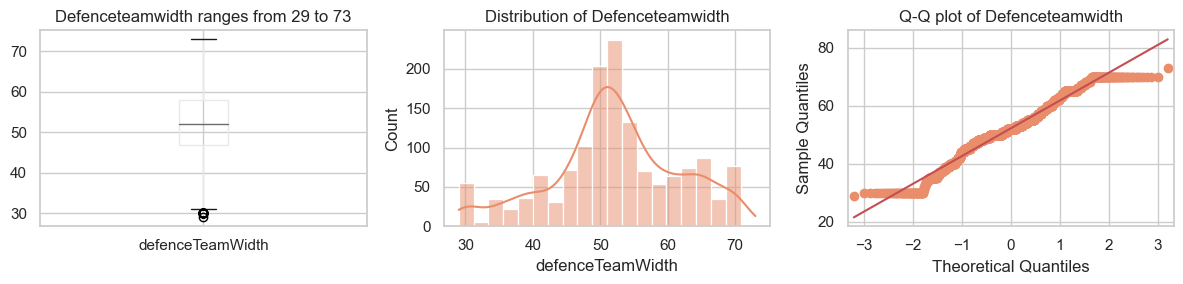

In [56]:
for features in [buildUp, chanceCreation, defence]:
    helpingtool.distribution_check(team_attributes[features])

None of the columns are strongly correlated.

c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:350: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True,


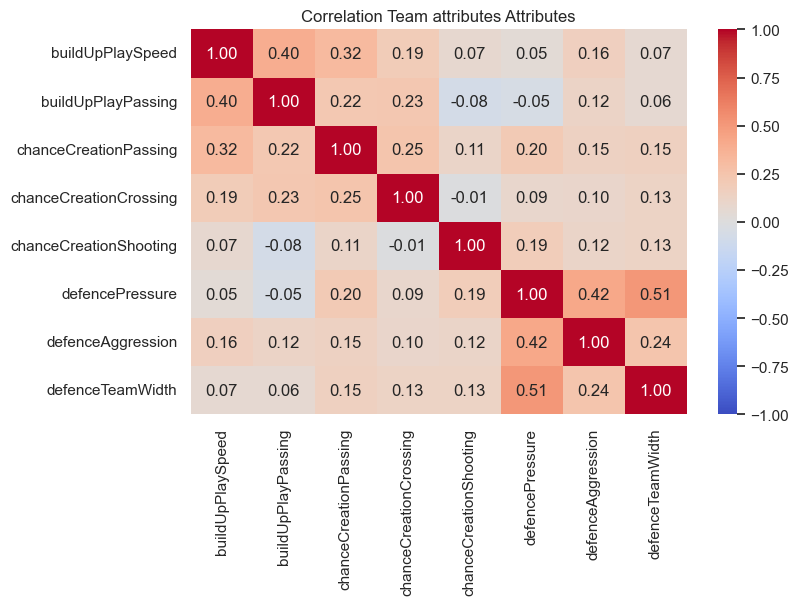

In [57]:
helpingtool.heatmap(
    team_attributes[buildUp+chanceCreation+defence], 'Team Attributes')

<h4>Categorical features and correlation</h5>
Spearman's rank correlation coefficient calculates the correlation based on the ranks of the values rather than the actual values themselves.

Null hypothesis: Class features do not have a correlation relationship. <br>
Alternative Hypotheses: Class features do have a correlation relationship.<br>

In [58]:
helpingtool.spearmans_corr(team_attributes, [
                           'buildUpPlayDribblingClass', 'buildUpPlayPositioningClass', 
                           'chanceCreationPositioningClass', 'defenceDefenderLineClass'])

buildUpPlayDribblingClass + buildUpPlayPositioningClass. p-value = 0.0331: Spearman's correlation:  0.0558
Reject null hypothesis
buildUpPlayDribblingClass + chanceCreationPositioningClass. p-value = 0.0522: Spearman's correlation:  0.0509
Fail to reject null hypothesis
buildUpPlayDribblingClass + defenceDefenderLineClass. p-value = 0.0000: Spearman's correlation:  -0.1471
Reject null hypothesis
buildUpPlayPositioningClass + chanceCreationPositioningClass. p-value = 0.0000: Spearman's correlation:  0.3516
Reject null hypothesis
buildUpPlayPositioningClass + defenceDefenderLineClass. p-value = 0.0000: Spearman's correlation:  -0.1947
Reject null hypothesis
chanceCreationPositioningClass + defenceDefenderLineClass. p-value = 0.0000: Spearman's correlation:  -0.1478
Reject null hypothesis


All categorical features are correlated, except buildUpPlayDribblingClass + chanceCreationPositioningClass.

<h4>Date</h4>
Date ranges 2010-2015

In [59]:
team_attributes['date'].describe()

C:\Users\Gintare\AppData\Local\Temp\ipykernel_8468\481763543.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  team_attributes['date'].describe()


count                    1457
unique                      6
top       2014-09-19 00:00:00
freq                      244
first     2010-02-22 00:00:00
last      2015-09-10 00:00:00
Name: date, dtype: object

<h4>Attribute Change in season </h4>
Team attributes do not change on the whole season.

In [60]:
team_attributes = duckdb.query("""
             SELECT * 
             ,CASE 
             WHEN MONTH(date) > 6 THEN CONCAT(year, '/', year+1) 
             ELSE CONCAT(year - 1, '/', year)
             END AS season 
             FROM (
                SELECT *, YEAR(date) as year
                FROM team_attributes
             ) a
""").to_df()

duckdb.query("""
             SELECT * FROM (
             
             SELECT  
             COUNT(team_api_id) OVER (PARTITION BY season, team_api_id) AS team_api_id_count

             ,season
             ,team_api_id
             FROM (
             SELECT DISTINCT team_api_id, buildUpPlaySpeedClass, 
             buildUpPlayDribblingClass, buildUpPlayPositioningClass, 
             chanceCreationPassingClass, chanceCreationCrossingClass, 
             chanceCreationShootingClass, chanceCreationPositioningClass,
             defencePressureClass, defenceAggressionClass, defenceTeamWidthClass, 
             defenceDefenderLineClass, season
             FROM team_attributes
             ) a ) a
             WHERE  team_api_id_count!=1

""").to_df().shape[0]

0

<H2>Multicollinearity</H2>
Features are multicollinear among each other.

In [61]:
helpingtool.vif(team_attributes[['buildUpPlaySpeed', 'buildUpPlayDribbling',
                                 'buildUpPlayPassing', 'chanceCreationPassing',
                                 'chanceCreationCrossing', 'chanceCreationShooting',
                                 'defencePressure', 'defenceAggression', 'defenceTeamWidth'
                                 ]][~team_attributes['buildUpPlayDribbling'].isna()])

,variables,VIF
0,buildUpPlaySpeed,36.480520
1,buildUpPlayDribbling,24.950343
2,buildUpPlayPassing,27.026910
3,chanceCreationPassing,35.872315
4,chanceCreationCrossing,33.470725
5,chanceCreationShooting,26.864528
6,defencePressure,37.955846
7,defenceAggression,42.777801
8,defenceTeamWidth,48.164213


<h2>Conclusion</h2>
Team attributes are made up of Categorical Class and Continues columns. 

Class columns are derived from Continues columns (except for 3 attributes). Continues columns will be used, when Class is not available.

Data ranges 2010-2015.
Team attributes don't change through the season.

Features are multicollinear among each other.

<h1>Match</H1>
Match has 25979 observations and 85 features.

In [62]:
match = helpingtool.dtype_update(match)
helpingtool.first_look(match)

Column data types:
win           object
id             int64
league_id      int64
season        object
stage          int64
               ...  
foulcommit    object
card          object
cross         object
corner        object
possession    object
Length: 85, dtype: object

Dataset has 25979 observations and 85 features
Columns with NULL values: ['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_

<h3>Missing values</h3>
X and Y coordinates soemtimes have 0 values, inplace of NaN. These will be updated to NaN.

In [63]:
match.filter(like='home_player_X', axis=1).describe(
).loc[['min', 'max']].transpose().reset_index()

,index,min,max
0,home_player_X1,0.0,2.0
1,home_player_X2,0.0,8.0
2,home_player_X3,1.0,8.0
3,home_player_X4,2.0,8.0
4,home_player_X5,1.0,9.0
5,home_player_X6,1.0,9.0
6,home_player_X7,1.0,9.0
7,home_player_X8,1.0,9.0
8,home_player_X9,1.0,9.0
9,home_player_X10,1.0,9.0


In [64]:
for prefix in ['home_player_X', 'home_player_Y']:
    for feature in match.filter(like=prefix, axis=1).columns:
        match.loc[match[feature] == 0, feature] = np.NaN

<h3>Data Coverage</h3>
Match has data on same home_team_api_id	and away_team_api_id	

In [65]:
duckdb.query("""
             WITH
             home_team AS (SELECT DISTINCT home_team_api_id FROM match)
             ,away_team AS (SELECT DISTINCT away_team_api_id FROM match)

             SELECT *
             FROM home_team h
             FULL OUTER JOIN away_team a
             ON h.home_team_api_id=a.away_team_api_id
             WHERE h.home_team_api_id IS NULL OR a.away_team_api_id IS NULL
             """).shape[0]

0

League and Match tables have the same leagues.

In [66]:
duckdb.query("""
             SELECT m.league_id, l.*
             FROM match m
             FULL OUTER JOIN league l 
             ON l.league_id = m.league_id
             WHERE l.league_id IS NULL OR m.league_id IS NULL
""").shape[0]

0

In [67]:
match = duckdb.query("""
             SELECT m.*, l.Country, l.League
             FROM match m
             JOIN league l ON l.league_id = m.league_id
""").to_df()

Some Leagues have different maximum stages.

In [68]:
match.groupby('Country')['stage'].max().reset_index(
).sort_values(by='stage', ascending=False)

,Country,stage
1,England,38
2,France,38
4,Italy,38
8,Scotland,38
9,Spain,38
10,Switzerland,36
0,Belgium,34
3,Germany,34
5,Netherlands,34
7,Portugal,34


<h3>Goal distribution</h3>

Goal has non normal distribution. As goal per match can go up to 10, but mostly 0-1-2.

In [69]:
player_positions = helpingtool.player_positions_extraction(match)

c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['type'] = prefix
c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['type'] = prefix
c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Team_goal


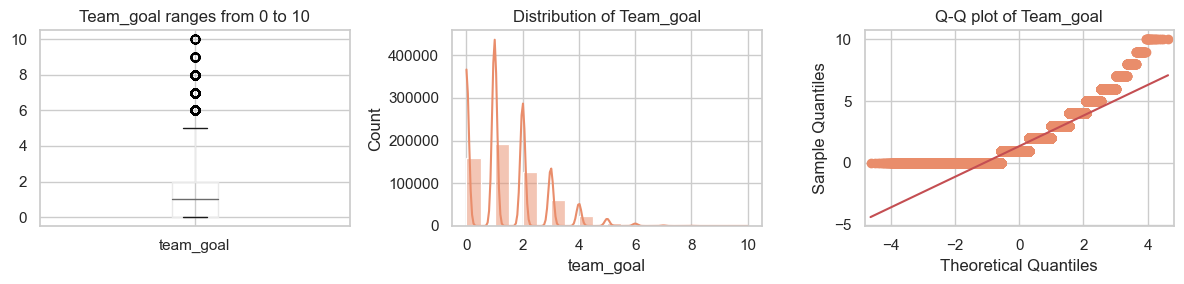

In [70]:
helpingtool.distribution_check(player_positions[['team_goal']])

<H1>Match attributes</H1>
'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession' can be extracted form a suplementary dataset.

* A "shot on" is a shot attempt that is directed towards the goal and is on target, meaning it could potentially result in a goal if not saved by the goalkeeper.
* A "shot off" is a shot attempt that misses the goal and does not result in a score.
* A "foul commit" occurs when a player violates the rules of the game by committing an offense against an opponent.
* A "card" is typically shown by the referee as a disciplinary action for a player's misconduct. A yellow card serves as a warning, while a red card results in the player's ejection from the match.
* A "cross" is a play where a player delivers the ball into the penalty area from a wide position, often from the wings.
* A "corner kick" is awarded when the ball goes out of play over the goal line, and the attacking team is given a kick from the corner flag.
* Possession percentages indicate the amount of time a team spent in control of the ball compared to the total match duration. It is often expressed as a percentage, such as "Team A had 60% possession."

In this work card and goal deatails are going to be overviewd.

In [71]:
position_reference = helpingtool.csv_download_match(r"PositionReference")
goal_detail = helpingtool.csv_download_match(r"goal")
card_detail = helpingtool.csv_download_match(r"card")

<H2>Goal Detail</H2>

In [72]:
goal_detail = helpingtool.dtype_update(goal_detail)
helpingtool.first_look(goal_detail)

Column data types:
elapsed           int64
elapsed_plus    float64
goal_type        object
match_id          int64
player1         float64
player2         float64
pos_x           float64
pos_y           float64
subtype          object
team            float64
type             object
dtype: object

Dataset has 39946 observations and 11 features
Columns with NULL values: ['elapsed_plus', 'player1', 'player2', 'pos_x', 'pos_y', 'subtype']
Dataset has 3 duplicates


<h3>Duplicates</h3>

In [73]:
goal_detail[goal_detail.duplicated(keep=False)]

,elapsed,elapsed_plus,goal_type,match_id,player1,player2,pos_x,pos_y,subtype,team,type
22515,90,NaN,n,10793,27734.0,NaN,NaN,NaN,NaN,8600.0,goal
22516,90,NaN,n,10793,27734.0,NaN,NaN,NaN,NaN,8600.0,goal
36229,90,NaN,n,23355,19243.0,NaN,NaN,NaN,NaN,9906.0,goal
36230,90,NaN,n,23355,19243.0,NaN,NaN,NaN,NaN,9906.0,goal
37095,45,NaN,n,23647,40958.0,NaN,NaN,NaN,NaN,10267.0,goal
37096,45,NaN,n,23647,40958.0,NaN,NaN,NaN,NaN,10267.0,goal


Checking on of the entry for match_id 10793: goal_detail has 3 goals for player 27734 in home teams and 1 goal for player 39535 in away team. Checking the match table, home team got 3 and away - 1 goals. These entries are true, but elapsed column could give false information.

In [74]:
goal_detail[goal_detail['match_id'] == 10793]

,elapsed,elapsed_plus,goal_type,match_id,player1,player2,pos_x,pos_y,subtype,team,type
22513,7,NaN,n,10793,27734.0,NaN,NaN,NaN,NaN,8600.0,goal
22514,21,NaN,n,10793,39535.0,NaN,NaN,NaN,NaN,9875.0,goal
22515,90,NaN,n,10793,27734.0,NaN,NaN,NaN,NaN,8600.0,goal
22516,90,NaN,n,10793,27734.0,NaN,NaN,NaN,NaN,8600.0,goal


In [75]:
match[match['id'] == 10793][['home_team_api_id',
                             'away_team_api_id', 'home_team_goal', 'away_team_goal']]

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
10792,8600,9875,3,1


<h3>Empty values</h3>
Values without player1 will be dropped.

In [76]:
goal_detail = goal_detail[~goal_detail['player1'].isna()]

Recreating the home-away teams scores from goal_detail, all goal values align. 

Goal amount between goal_detail and match is the same, it's most likely that 3 entries in elapsed column has incorrect values or elapsed_plus is missing values. Duplicates will not be dropped.

In [77]:
duckdb.query("""
             WITH
             match_goal_details AS (
             SELECT 
             id, home_team_goal, away_team_goal, home_team_api_id, away_team_api_id
             FROM match
             )

             ,goal_goal_details AS (
             SELECT 
             match_id, team
             , SUM(n_goal) AS n_goal,  SUM(p_goal) AS p_goal, SUM(o_goal) AS o_goal
             FROM(
             SELECT match_id, team
             ,CASE goal_type WHEN 'n' THEN 1 END AS n_goal
             ,CASE goal_type WHEN 'p' THEN 1 END AS p_goal
             ,CASE goal_type WHEN 'o' THEN 1 END AS o_goal
             FROM goal_detail
             ) a
             GROUP BY match_id, team
             ) 

             SELECT * FROM (
             
             SELECT 
             m.*, 
             h.n_goal AS h_n_goal, h.p_goal AS h_p_goal,h.o_goal AS h_o_goal,
             a.n_goal AS a_n_goal, a.p_goal AS a_p_goal,a.o_goal AS a_o_goal

             FROM match_goal_details m
             JOIN goal_goal_details h ON m.id = h.match_id AND m.home_team_api_id = h.team
             JOIN goal_goal_details a ON m.id = a.match_id AND m.away_team_api_id = a.team
             ) a

             WHERE 
             home_team_goal != (h_n_goal + h_p_goal + a_o_goal)
             AND away_team_goal != (a_n_goal + a_p_goal + h_o_goal)
             """).to_df().shape[0]

0

Goal type has 7 entries, but only n (goal), p (penalty) and o (owngoal) is a legitimate goal.

In [78]:
goal_detail['goal_type'].value_counts()

n      34516
p       2975
o       1113
npm      728
dg       519
rp        11
psm        1
Name: goal_type, dtype: int64

<h3>Do teams that have scorring players move around more have a better chance of a win?</h3>

<h3>Position</h3>
Goal position (position in a court where player scores) is not the same scale as match table. Goal coordinates will be scaled to alow for position names.

In [79]:
goal_detail[['pos_x', 'pos_y']].describe().loc[['min', 'max']]

,pos_x,pos_y
min,1.0,1.0
max,45.0,69.0


In [80]:
helpingtool.position_range_update(goal_detail)

<H2>Card</H2>

In [81]:
card_detail = helpingtool.dtype_update(card_detail)
helpingtool.first_look(card_detail)

Column data types:
card_type        object
elapsed           int64
elapsed_plus    float64
goal_type        object
match_id          int64
player1          object
subtype          object
team            float64
type             object
dtype: object

Dataset has 61792 observations and 9 features
Columns with NULL values: ['elapsed_plus', 'goal_type', 'subtype']
Dataset has 3 duplicates


In [82]:
card_detail['goal_type'].value_counts()

p    1
Name: goal_type, dtype: int64

In [83]:
card_detail['card_type'].value_counts()

y     58307
r      1768
y2     1717
Name: card_type, dtype: int64

Duplicates will not be dropped, as goal table has false duplicates, but in card details it's not posible to chekc if these duplicates are true.

Missing values for player1 will also be dropped.

In [84]:
card_detail = card_detail[(card_detail['player1'] !=
                          'Unknown player') & (~card_detail['player1'].isna())]

<h1>Tableau dashboard</h1>

In [85]:
team_events = duckdb.query("""
             WITH 
             teams_in_leagues AS (
             SELECT 
                win, id, league_id, season, stage, date, match_api_id, 
                home_team_api_id AS team_api_id, home_team_goal AS team_goal, 'home' AS type
             FROM match
                           
             UNION 
                           
             SELECT 
                win, id, league_id, season, stage, date, match_api_id, 
                away_team_api_id AS team_api_id, away_team_goal AS team_goal, 'away' AS type
             FROM match
             )

             ,final AS (
             SELECT 
             l.League, n.team_long_name
             ,t.*
             FROM teams_in_leagues t 
             LEFT JOIN league l ON l.league_id=t.league_id
             LEFT JOIN team n ON n.team_api_id=t.team_api_id
             )

             SELECT League, team_long_name
             ,CASE 
             WHEN win = type THEN 'win' 
             WHEN win = 'draw' THEN 'draw'
             ELSE 'loss'
             END AS outcome
             ,id, season, stage, date, match_api_id, team_api_id, team_goal, type
             FROM final

             """).to_df()
team_events.to_csv('team_events.csv')

In [86]:
def dummy_columns(df, feature_list):
    df_dummies = pd.get_dummies(df[feature_list], drop_first=True)
    df = pd.concat([df, df_dummies], axis=1)
    return df

# Example usage:
goal_detail = helpingtool.dummy_columns(goal_detail, ['goal_type'])
card_detail = helpingtool.dummy_columns(card_detail, ['card_type'])

In [87]:
player_positions_for_goal=helpingtool.player_positions_extraction(match)

c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['type'] = prefix
c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['type'] = prefix
c:\Users\Gintare\Desktop\Study\Module2\Capstone\tools\helpingtool.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [88]:
player_positions_for_goal = player_positions_for_goal[~player_positions_for_goal['player'].isna()]

In [89]:
for i in ['id', 'player']:
    player_positions_for_goal[i]=player_positions_for_goal[i].astype(int)
for i in ['player1', 'team']:
    goal_detail[i]=goal_detail[i].astype(int)
    card_detail[i]=card_detail[i].astype(int)

In [90]:
missing_player_rating = duckdb.query("""

             SELECT 
             COALESCE(p.player, a.player_api_id) AS player_api_id
             ,COALESCE(p.date, a.date) AS date
             ,a.overall_rating, a.preferred_foot
             FROM player_positions_for_goal p
             FULL OUTER JOIN player_attributes a ON a.player_api_id=p.player AND a.date=p.date         

             """).to_df()

for feature in ['overall_rating', 'preferred_foot']:
    missing_player_rating[feature] = missing_player_rating.groupby('player_api_id')[
        feature].ffill()
    missing_player_rating[feature] = missing_player_rating.groupby('player_api_id')[
        feature].bfill()

In [91]:
player_details=duckdb.query("""
                            SELECT DISTINCT * FROM (
             SELECT p.id, p.match_api_id, p.team_api_id, p.player AS player_api_id
             ,r.role_xy AS role
             ,pl.player_name, YEAR(p.date)-YEAR(pl.birthday) AS age, pl.BMI
             ,a.overall_rating, a.preferred_foot
             FROM player_positions_for_goal p
             JOIN position_reference r ON r.player_pos_x=p.X AND r.player_pos_Y=p.Y
             JOIN player as pl ON pl.player_api_id=p.player
             JOIN missing_player_rating a ON a.player_api_id=p.player AND a.date=p.date)
             """).to_df()

In [92]:
goal_card_event = duckdb.query("""
    WITH 
    goal_info AS (
        SELECT 
            match_id, 
            player1,team,
            SUM(goal_type_n) + SUM(goal_type_p) AS goal,
            SUM(goal_type_npm) AS goal_type_npm,
            SUM(goal_type_o) AS owngoal,
            SUM(goal_type_psm) + SUM(goal_type_rp)  AS goal_type_psm,
        FROM goal_detail
        GROUP BY match_id, player1,team
    )

    ,card_info AS (
        SELECT 
            match_id,
            player1,team,
            SUM(card_type_y) + SUM(card_type_y2) AS card_type_y
        FROM card_detail
        GROUP BY match_id, player1,team
    )    

    
    SELECT 
    COALESCE(p.player_api_id, g.player1, c.player1) AS player_api_id
    ,COALESCE(p.id, g.match_id, c.match_id) AS id
    ,COALESCE(p.team_api_id, g.team, c.team) AS team_api_id
    ,match_api_id
    ,role, player_name, age, BMI, overall_rating, preferred_foot
    ,goal, goal_type_npm, owngoal
    ,goal_type_psm, card_type_y

    FROM player_details p
    JOIN goal_info g ON p.player_api_id = g.player1 AND p.id = g.match_id
    JOIN card_info c ON p.player_api_id = c.player1 AND p.id = c.match_id
    WHERE p.player_api_id IS NOT NULL

""").to_df()
goal_card_event.to_csv('goal_card_event.csv')

Tableau Link: https://public.tableau.com/app/profile/gintare6386/viz/EurporeanFootball/PlayerandTeamstatistics

<h1>Conclussion</h1>

Team attributes: 
* Team attributes don't change throught the season. 
* Date ranges 2010-2015
* Some Categorical columns overlap with Continues variables

Player attributes: 
* Player attributes do change throught the season. 
* Date ranges 2007-2016
* Variables are skill describing, similar variables have been aggregated for simplicity.

Match:
* Goals are non normaly ditributed, as the most common goal count is 0-1-2. But can go up to 10.